In [1]:
import os, sys, platform, yaml, re
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window
from pyspark.sql import DataFrame
from pyspark.sql.types import DoubleType, FloatType, StringType
from pathlib import Path
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.utils.statistics import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf as sm_acf, pacf as sm_pacf
# Para reproducibilidad en pandas (no afecta Spark)
np.random.seed(42)

# Preparación

In [2]:
conf_path = str(Path.cwd() / "config" / "ETL_config.yaml")
with open(conf_path, "r") as f:
    CFG = yaml.safe_load(f)

IS_WIN          = platform.system() == "Windows"
CSV_DIR         = CFG["paths"]["csv_base_dir"]["windows" if IS_WIN else "linux"]
PG_URL          = CFG["postgres"]["url"]
PG_USER         = CFG["postgres"]["user"]
PG_PASS         = CFG["postgres"]["pass"]
PG_SCHEMA       = CFG["postgres"]["schema_out"]["schema_name"]
PG_TABLE1       = CFG["postgres"]["schema_out"]["table1"]
PG_TABLE2       = CFG["postgres"]["schema_out"]["table2"]
PG_TABLE3       = CFG["postgres"]["schema_out"]["table3"]
FILES           = CFG["csv"]["files"]
NUM_PARTITIONS  = CFG["csv"]["num_partitions"]
JDBC_BATCHSIZE  = CFG["postgres"]["batchsize"]
JDBC_FETCHSIZE  = CFG["postgres"]["fetchsize"]
SPARK_LOCAL_DIR = CFG["spark"]["local_dirs"]["windows" if IS_WIN else "linux"]
NEO4J_URI  = CFG["neo4j"]["uri"]          # "bolt://localhost:7687"
NEO4J_USER = CFG["neo4j"]["user"]
NEO4J_PASS = CFG["neo4j"]["pass"]
NEO4J_DB   = CFG["neo4j"]["database"]

opts = {
    "url": NEO4J_URI,
    "authentication.type": "basic",
    "authentication.basic.username": NEO4J_USER,
    "authentication.basic.password": NEO4J_PASS,
    "database": NEO4J_DB,
}

os.environ["PYSPARK_PYTHON"] = sys.executable       # usa el Python del kernel actual
os.environ["JAVA_HOME"] = os.environ.get("JAVA_HOME", "/usr/lib/jvm/java-17-openjdk-amd64") #Chequear versión Windows después
Path(SPARK_LOCAL_DIR).mkdir(parents=True, exist_ok=True)


In [3]:
builder = (
    SparkSession.builder
    .master("local[*]")  
    .appName(CFG["spark"]["app_name"])
    .config("spark.sql.shuffle.partitions", str(CFG["spark"]["shuffle_partitions"]))
    .config("spark.driver.memory", CFG["spark"]["driver_memory"])
    .config("spark.driver.bindAddress", "127.0.0.1")
    .config("spark.driver.host", "127.0.0.1")
    .config("spark.local.dir", SPARK_LOCAL_DIR)   
    #.config("spark.jars.packages", ",".join(CFG["spark"]["local_jars"]["linux"]))
    .config(
        "spark.jars.packages",
        ",".join([
            "org.postgresql:postgresql:42.7.4",
            "org.neo4j:neo4j-connector-apache-spark_2.12:5.3.10_for_spark_3"
        ])
    )
)

spark = builder.getOrCreate()
spark.sparkContext.setLogLevel("WARN")

jdbc_props = {
        "user": PG_USER,
        "password": PG_PASS,
        "driver": "org.postgresql.Driver",
        "fetchsize": str(JDBC_FETCHSIZE)
    }


25/11/21 13:05:50 WARN Utils: Your hostname, AsusMare resolves to a loopback address: 127.0.1.1; using 192.168.100.4 instead (on interface wlp2s0)
25/11/21 13:05:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/opt/spark-3.5.3-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/felpipe/.ivy2/cache
The jars for the packages stored in: /home/felpipe/.ivy2/jars
org.postgresql#postgresql added as a dependency
org.neo4j#neo4j-connector-apache-spark_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-24ad2ce6-c1b4-431a-bf7c-8f13c5118584;1.0
	confs: [default]
	found org.postgresql#postgresql;42.7.4 in central
	found org.checkerframework#checker-qual;3.42.0 in central
	found org.neo4j#neo4j-connector-apache-spark_2.12;5.3.10_for_spark_3 in central
	found org.neo4j#neo4j-connector-apache-spark_2.12_common;5.3.10_for_spark_3 in central
	found org.neo4j#caniuse-core;1.3.0 in local-m2-cache
	found org.neo4j#caniuse-api;1.3.0 in local-m2-cache
	found org.jetbrains.kotlin#kotlin-stdlib;2.1.20 in local-m2-cache
	found org.jetbrains#annotations;13.0 in local-m2-cache
	found org.neo4j#caniuse-neo4j-detection;1.3.0 in local-m2-cache
	found org.neo4j.driver#neo4j-java-driver-slim;4.4.21 in local-m2-cache
	

In [4]:
df_acc = (spark.read.format("jdbc")
        .option("url", PG_URL)
        .option("dbtable", f"{PG_SCHEMA}.{PG_TABLE1}")
        .option("partitionColumn", "account")
        .option("lowerBound", 1)                  
        .option("upperBound", 2000000)
        .option("numPartitions", 16)               
        .options(**jdbc_props)
        .load())

df_txs = (spark.read.format("jdbc")
        .option("url", PG_URL)
        .option("dbtable", f"{PG_SCHEMA}.{PG_TABLE2}")
        .option("partitionColumn", "id")
        .option("lowerBound", 1)
        .option("upperBound", 9500000)
        .option("numPartitions", 64)
        .options(**jdbc_props)
        .load())

acc_bounds = df_acc.select(
        F.min("account").cast("long").alias("lo"),
        F.max("account").cast("long").alias("hi")
    ).first()
acc_lo, acc_hi = int(acc_bounds["lo"]), int(acc_bounds["hi"])

df_sta =  (spark.read.format("jdbc")
        .option("url", PG_URL)
        .option("dbtable", f"{PG_SCHEMA}.{PG_TABLE3}")
        .option("partitionColumn", "account")       # particionamos por cuenta
        .option("lowerBound", acc_lo)
        .option("upperBound", acc_hi)
        .option("numPartitions", 64)                 # ajústalo a tu máquina/cluster
        .options(**jdbc_props)
        .load()
        .select(
            F.col("account").cast("long").alias("account"),
            F.col("date_time").alias("date_time"),
            F.col("txn_id").cast("long").alias("txn_id"),
            F.col("direction").alias("direction"),
            F.col("delta_amount").cast("double").alias("delta_amount"),
            F.col("running_balance").cast("double").alias("running_balance")
        )
    )

# EDA Temporal

## Selección de ventana

In [5]:
expected_cols = {
    "id", "date_time", "sender_account", "receiver_account",
    "amount", "payment_currency", "received_currency",
    "payment_type", "is_laundering", "laundering_type"
}

missing = expected_cols - set(df_txs.columns)
if missing:
    raise ValueError(f"Faltan columnas en df_txs: {missing}")

# Filtra nulos en timestamp y valores negativos/NaN en amount si corresponde.
df_tx_clean = (
    df_txs
    .filter(F.col("date_time").isNotNull())
    .filter(F.col("amount").isNotNull())
)

In [6]:
print('Fechas mínima y máximas del dataset')
df_txs.agg(
    F.min("date_time").alias("min_date"),
    F.max("date_time").alias("max_date")
).show()

df_txs.agg(
        (F.datediff(F.max("date_time"), F.min("date_time"))).alias("dias_entre_fechas")
    ).show()

#Granularidades candidatas
granularities = ["1 hour", "3 hour", "6 hour", "12 hour", "1 day", "3 day", "1 week"]

Fechas mínima y máximas del dataset


+-------------------+-------------------+
|           min_date|           max_date|
+-------------------+-------------------+
|2022-10-07 10:35:19|2023-08-23 10:57:12|
+-------------------+-------------------+



[Stage 6:==================================================>      (57 + 7) / 64]

+-----------------+
|dias_entre_fechas|
+-----------------+
|              320|
+-----------------+



In [7]:
#Función de agregación global por ventana
def aggregate_by_window(df: DataFrame, window_size: str) -> DataFrame:
    """
    Agrega métricas globales por ventana temporal.
    - n_txs: número de transacciones
    - total_amount: monto total
    - n_senders, n_receivers: cuentas únicas activas
    Devuelve columnas: [start, end, n_txs, total_amount, n_senders, n_receivers]
    """
    agg = (
        df
        .groupBy(F.window("date_time", window_size))
        .agg(
            F.count("*").alias("n_txs"),
            F.sum("amount").alias("total_amount"),
            F.countDistinct("sender_account").alias("n_senders"),
            F.countDistinct("receiver_account").alias("n_receivers"),
        )
        .withColumn("start", F.col("window").start)
        .withColumn("end",   F.col("window").end)
        .drop("window")
        .orderBy("start")
    )
    return agg


In [8]:
#Métricas de selección de ventana en pandas
# def stability_autocorr(series: pd.Series, lag:int=1) -> float:
#     """
#     Estabilidad como autocorrelación de lag=1 (Pearson).
#     Devuelve NaN si la serie es constante o <2 puntos.
#     """
#     if series is None or len(series) < 2:
#         return np.nan
#     # Si la varianza es 0, autocorr de pandas devuelve NaN -> lo respetamos.
#     return series.autocorr(lag=lag)

def stability_autocorr(series, lag=1): #ESta versión no penaliza el signo, es decir busca la fuerza de |p|
    r = series.autocorr(lag=lag)
    return abs(r) if not pd.isna(r) else np.nan

def variance_ratio(series: pd.Series) -> float:
    """
    Varianza relativa: std / mean (CV).
    Si mean=0, devuelve NaN para evitar divisiones inválidas.
    """
    if series is None or len(series) == 0:
        return np.nan
    mu = series.mean()
    sigma = series.std(ddof=1)
    return (sigma / mu) if (mu and mu != 0) else np.nan

def evaluate_granularity(df_agg_pd: pd.DataFrame, value_col:str="n_tx") -> dict:
    """
    Calcula métricas de evaluación sobre la serie df_agg_pd[value_col].
    """
    s = df_agg_pd[value_col].astype(float)
    stab = stability_autocorr(s, lag=1)
    varr = variance_ratio(s)
    # También podemos capturar "volatilidad de primera diferencia"
    diff = s.diff().dropna()
    vr_diff = variance_ratio(diff) if len(diff) > 1 else np.nan
    return {
        "stability": float(stab) if stab == stab else np.nan,  # nan check
        "variance_ratio": float(varr) if varr == varr else np.nan,
        "variance_ratio_diff": float(vr_diff) if vr_diff == vr_diff else np.nan,
        "n_points": int(len(s))
    }


In [9]:
#Loop principal. Agrega, evalúa y guarda resultados

results = []           # métricas por granularidad
agg_by_g = {}          # guardamos los agregados Spark por si los necesitamos luego

for g in granularities:
    agg_df = aggregate_by_window(df_tx_clean, g)
    agg_by_g[g] = agg_df.cache()  # cache ligero; puedes persist(StorageLevel.MEMORY_AND_DISK) si lo usarás bastante
    
    # Convertimos a pandas SOLO los agregados (pequeños en comparación al total)
    pdf = agg_df.toPandas().sort_values("start").reset_index(drop=True)
    # Asegúrate de que 'start' es datetime nativo
    pdf["start"] = pd.to_datetime(pdf["start"])
    pdf["end"]   = pd.to_datetime(pdf["end"])
    
    metrics = evaluate_granularity(pdf, value_col="n_txs")
    metrics.update({"granularity": g})
    results.append(metrics)

df_eval = pd.DataFrame(results).sort_values("granularity")
df_eval

,stability,variance_ratio,variance_ratio_diff,n_points,granularity
4,0.319303,0.067111,-404.038002,321,1 day
0,0.821759,0.492004,2766.901109,7681,1 hour
6,0.334091,0.049387,14.816941,46,1 week
3,0.944006,0.359003,-592.695935,641,12 hour
5,0.336695,0.047723,-397.227809,107,3 day
1,0.517411,0.461198,1551.992678,2561,3 hour
2,0.081679,0.399892,-2875.788204,1281,6 hour


In [10]:
# Elección automática de la "Mejor ventana"
# Criterio: balancear estabilidad alta, y varianza_relativa NO demasiado baja.
# Definimos un score normalizado: score = w1 * stability_norm - w2 * variance_ratio_norm
# (donde normalizamos columna a [0,1], ignorando NaNs)

def minmax_norm(x: pd.Series):
    x = x.astype(float)
    xmin, xmax = np.nanmin(x), np.nanmax(x)
    if not np.isfinite(xmin) or not np.isfinite(xmax) or xmin == xmax:
        return pd.Series([np.nan]*len(x), index=x.index)
    return (x - xmin) / (xmax - xmin)

df_eval_scored = df_eval.copy()
for col in ["stability", "variance_ratio"]:
    df_eval_scored[col+"_norm"] = minmax_norm(df_eval_scored[col])

# Pesos (ajustables):
w_stab = 0.65
w_var  = 0.35

df_eval_scored["score"] = (
    w_stab * df_eval_scored["stability_norm"] -
    w_var  * df_eval_scored["variance_ratio_norm"]
)

# Si quieres exigir estabilidad mínima (p.ej., >= 0.4):
df_eval_scored["eligible"] = df_eval_scored["stability"].fillna(-1) >= 0.4
candidates = df_eval_scored[df_eval_scored["eligible"]]
if len(candidates) == 0:
    # Si no hay elegibles, tomamos el mejor score global
    best_row = df_eval_scored.sort_values("score", ascending=False).iloc[0]
else:
    best_row = candidates.sort_values("score", ascending=False).iloc[0]

best_window = best_row["granularity"]
best_row


stability                0.944006
variance_ratio           0.359003
variance_ratio_diff   -592.695935
n_points                      641
granularity               12 hour
stability_norm                1.0
variance_ratio_norm      0.700639
score                    0.404776
eligible                     True
Name: 3, dtype: object

La selección de ventana es de 12 horas para este set en particular. El score, con ponderaciones de 0.65 en estabilidad, y 0.35 en variabilidad favorece ampliamente esta ventana.

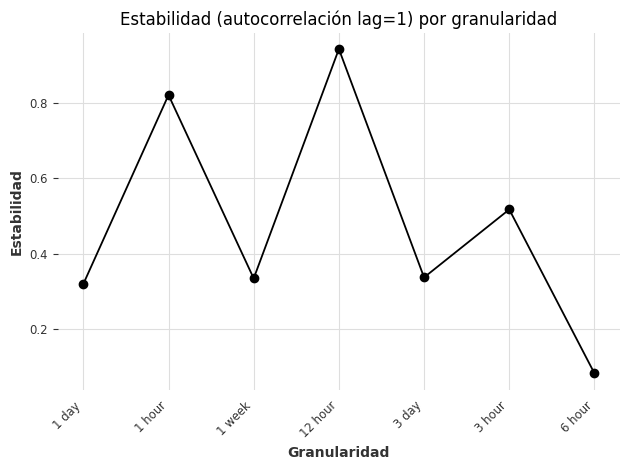

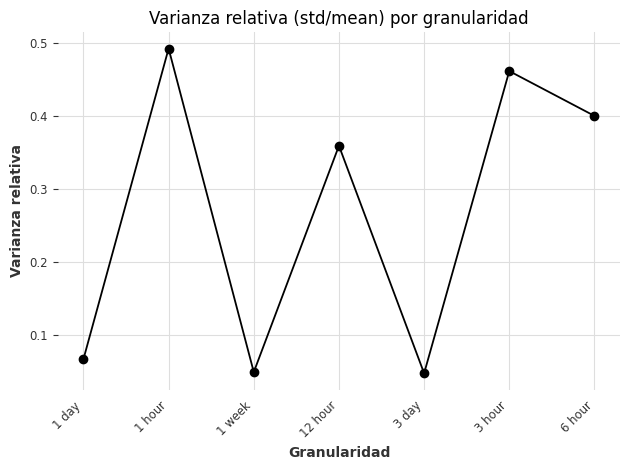

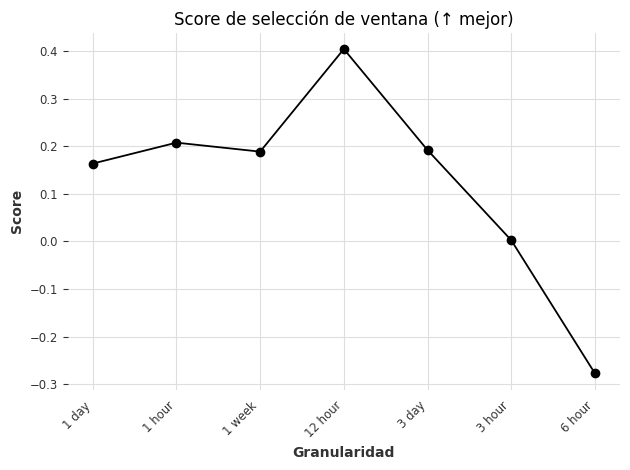

In [11]:
# a) Estabilidad vs Granularidad
plt.figure()
plt.plot(df_eval_scored["granularity"], df_eval_scored["stability"], marker="o")
plt.xticks(rotation=45, ha="right")
plt.title("Estabilidad (autocorrelación lag=1) por granularidad")
plt.xlabel("Granularidad")
plt.ylabel("Estabilidad")
plt.tight_layout()
plt.show()

# b) Varianza relativa vs Granularidad
plt.figure()
plt.plot(df_eval_scored["granularity"], df_eval_scored["variance_ratio"], marker="o")
plt.xticks(rotation=45, ha="right")
plt.title("Varianza relativa (std/mean) por granularidad")
plt.xlabel("Granularidad")
plt.ylabel("Varianza relativa")
plt.tight_layout()
plt.show()

# c) Score combinado
plt.figure()
plt.plot(df_eval_scored["granularity"], df_eval_scored["score"], marker="o")
plt.xticks(rotation=45, ha="right")
plt.title("Score de selección de ventana (↑ mejor)")
plt.xlabel("Granularidad")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


La versión gráfica del score muestra la clara preferencia por la ventana de 12 horas

Ventana sugerida: 12 hour
Total ventanas: 641
Spikes (n_tx) con |z| >= 3.0: 0
Spikes (total_amount) con |z| >= 3.0: 0


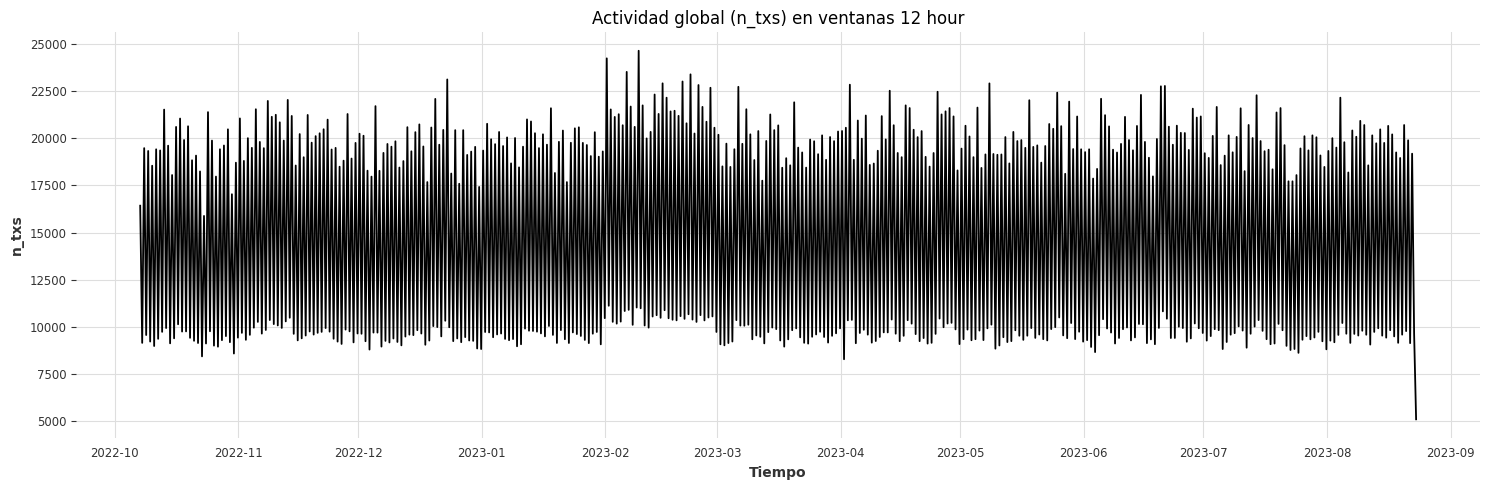

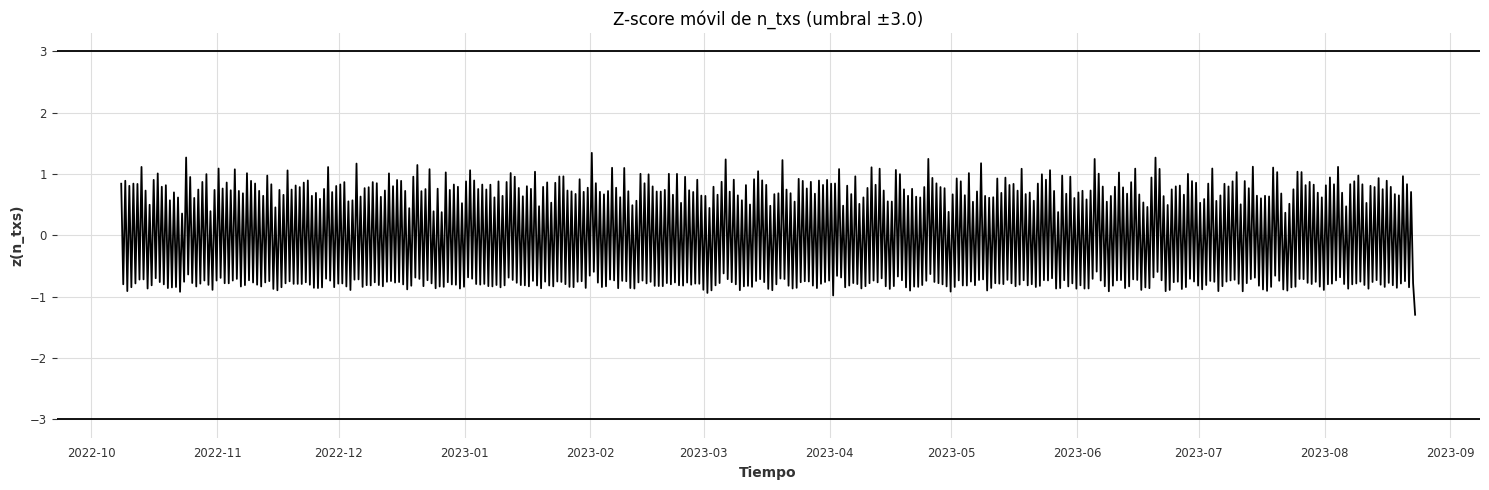

In [12]:
#Serie en la mejor ventana y detección de spikes

best_agg_sdf = agg_by_g[best_window]
best_pdf = best_agg_sdf.toPandas().sort_values("start").reset_index(drop=True)
best_pdf["start"] = pd.to_datetime(best_pdf["start"])
best_pdf["end"]   = pd.to_datetime(best_pdf["end"])

# Función de z-score rolling (para robustecer contra no-estacionariedad)
def rolling_zscore(x: pd.Series, window:int=7) -> pd.Series:
    # mean y std móviles; evitar valores iniciales NaN hasta que haya ventana suficiente
    roll_mean = x.rolling(window=window, min_periods=max(2, window//2)).mean()
    roll_std  = x.rolling(window=window, min_periods=max(2, window//2)).std(ddof=1)
    z = (x - roll_mean) / roll_std
    return z

# Calculamos z-score móvil sobre n_tx y total_amount
for col in ["n_txs", "total_amount"]:
    best_pdf[f"z_{col}"] = rolling_zscore(best_pdf[col].astype(float), window=7)

# Umbral de spike (ajustable). 3 es estándar; para datos muy ruidosos, 3.5–4.
Z_THR = 3.0

spikes_tx = best_pdf[np.abs(best_pdf["z_n_txs"]) >= Z_THR].copy()
spikes_amt = best_pdf[np.abs(best_pdf["z_total_amount"]) >= Z_THR].copy()

print(f"Ventana sugerida: {best_window}")
print(f"Total ventanas: {len(best_pdf)}")
print(f"Spikes (n_tx) con |z| >= {Z_THR}: {len(spikes_tx)}")
print(f"Spikes (total_amount) con |z| >= {Z_THR}: {len(spikes_amt)}")

# Gráficos de la serie y z-score (n_tx)
plt.figure(figsize=(15, 5))
plt.plot(best_pdf["start"], best_pdf["n_txs"])
plt.title(f"Actividad global (n_txs) en ventanas {best_window}")
plt.xlabel("Tiempo")
plt.ylabel("n_txs")
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(best_pdf["start"], best_pdf["z_n_txs"])
plt.axhline(Z_THR)
plt.axhline(-Z_THR)
plt.title(f"Z-score móvil de n_txs (umbral ±{Z_THR})")
plt.xlabel("Tiempo")
plt.ylabel("z(n_txs)")
plt.tight_layout()
plt.show()

## HUBs

Se busca hacer análisis de series de tiempo de cuatro nodos, en particular deben ser hubs con alta cantidad de transferencias. Se requiere de dos pares de nodos con bajo porcentaje de transferencias fraudulentas, y otros dos con alto porcentaje. Para cada par un elemento tiene que ser hub en transferencias de salida, y el otro de entrada. Se analizarán patrones como periodicidad y estacionalidad. La ventana de tiempo no es completamente necesaria, pero sí útil.

In [13]:
df_sender_hubs = (
    df_txs
    .groupBy(F.col('sender_account'))
    .agg(
        F.count('*').alias('n_transfers'),
        F.sum(F.when(F.col('is_laundering') == 1, 1).otherwise(0)).alias('n_laundering'),
        F.sum(F.when(F.col('is_laundering') == 0, 1).otherwise(0)).alias('n_not_laundering')
    )
    .withColumn(
        'pct_laundering',
        F.round((F.col('n_laundering') / F.col('n_transfers')) * 100, 2)
    )
    .withColumn(
        'pct_not_laundering',
        F.round((F.col('n_not_laundering') / F.col('n_transfers')) * 100, 2)
    )
)

df_receiver_hubs = (
    df_txs
    .groupBy(F.col('receiver_account'))
    .agg(
        F.count('*').alias('n_transfers'),
        F.sum(F.when(F.col('is_laundering') == 1, 1).otherwise(0)).alias('n_laundering'),
        F.sum(F.when(F.col('is_laundering') == 0, 1).otherwise(0)).alias('n_not_laundering')
    )
    .withColumn(
        'pct_laundering',
        F.round((F.col('n_laundering') / F.col('n_transfers')) * 100, 2)
    )
    .withColumn(
        'pct_not_laundering',
        F.round((F.col('n_not_laundering') / F.col('n_transfers')) * 100, 2)
    )
)

In [14]:
top_sender_laundering_hub = df_sender_hubs \
    .orderBy(
        F.desc('pct_laundering'),
        F.desc('n_transfers')
        ) \
    .collect()[2]['sender_account'] #Se priorizó un hub con un número de transferencias "alto"

df_sender_hubs \
    .orderBy(
        F.desc('pct_laundering'),
        F.desc('n_transfers'),
        ) \
    .show()

[Stage 140:=====================================================> (62 + 2) / 64]

+--------------+-----------+------------+----------------+--------------+------------------+
|sender_account|n_transfers|n_laundering|n_not_laundering|pct_laundering|pct_not_laundering|
+--------------+-----------+------------+----------------+--------------+------------------+
|    5917350547|          9|           9|               0|         100.0|               0.0|
|    2247370907|         24|          23|               1|         95.83|              4.17|
|    4159678387|         40|          37|               3|          92.5|               7.5|
|    2488893433|         29|          26|               3|         89.66|             10.34|
|    5008453588|         28|          25|               3|         89.29|             10.71|
|    3864360347|         23|          20|               3|         86.96|             13.04|
|    1865451606|         28|          24|               4|         85.71|             14.29|
|    4220180108|          7|           6|               1|         85.

In [15]:
top_receiver_laundering_hub = df_receiver_hubs \
    .orderBy(
        F.desc('pct_laundering'),
        F.desc('n_transfers')
        ) \
    .collect()[0]['receiver_account']

df_receiver_hubs \
    .orderBy(
        F.desc('pct_laundering'),
        F.desc('n_transfers'),
        ) \
    .show()

[Stage 151:======================================================>(63 + 1) / 64]

+----------------+-----------+------------+----------------+--------------+------------------+
|receiver_account|n_transfers|n_laundering|n_not_laundering|pct_laundering|pct_not_laundering|
+----------------+-----------+------------+----------------+--------------+------------------+
|        57359957|         26|          26|               0|         100.0|               0.0|
|      4465839311|         24|          24|               0|         100.0|               0.0|
|      3282818329|         23|          23|               0|         100.0|               0.0|
|      7748494288|         23|          23|               0|         100.0|               0.0|
|      4810948357|         20|          20|               0|         100.0|               0.0|
|        86715269|         18|          18|               0|         100.0|               0.0|
|      5200865572|         16|          16|               0|         100.0|               0.0|
|      3474569692|         13|          13|       

In [16]:
cleanest_sender_hub = df_sender_hubs \
    .orderBy(
        F.asc('pct_laundering'),
        F.desc('n_transfers')
        ) \
    .collect()[0]['sender_account']

df_sender_hubs \
    .orderBy(
        F.asc('pct_laundering'),
        F.desc('n_transfers'),
        ) \
    .show()

[Stage 162:====================================================>  (61 + 3) / 64]

+--------------+-----------+------------+----------------+--------------+------------------+
|sender_account|n_transfers|n_laundering|n_not_laundering|pct_laundering|pct_not_laundering|
+--------------+-----------+------------+----------------+--------------+------------------+
|    3831533348|        749|           0|             749|           0.0|             100.0|
|     798082205|        743|           0|             743|           0.0|             100.0|
|    5435316010|        731|           0|             731|           0.0|             100.0|
|    4724445469|        731|           0|             731|           0.0|             100.0|
|    4109275762|        720|           0|             720|           0.0|             100.0|
|     244442078|        713|           0|             713|           0.0|             100.0|
|    4492659500|        712|           0|             712|           0.0|             100.0|
|    4924631375|        706|           0|             706|           0

In [17]:
cleanest_receiver_hub = df_receiver_hubs \
    .orderBy(
        F.asc('pct_laundering'),
        F.desc('n_transfers')
        ) \
    .collect()[0]['receiver_account']

df_receiver_hubs \
    .orderBy(
        F.asc('pct_laundering'),
        F.desc('n_transfers'),
        ) \
    .show()

[Stage 173:================================================>      (56 + 8) / 64]

+----------------+-----------+------------+----------------+--------------+------------------+
|receiver_account|n_transfers|n_laundering|n_not_laundering|pct_laundering|pct_not_laundering|
+----------------+-----------+------------+----------------+--------------+------------------+
|      8600542721|        751|           0|             751|           0.0|             100.0|
|      2938210715|        745|           0|             745|           0.0|             100.0|
|      5460360634|        740|           0|             740|           0.0|             100.0|
|      5579295130|        739|           0|             739|           0.0|             100.0|
|      4808614002|        737|           0|             737|           0.0|             100.0|
|      4724445469|        736|           0|             736|           0.0|             100.0|
|      9544431251|        734|           0|             734|           0.0|             100.0|
|      4924631375|        734|           0|       

In [18]:
#Dataframes que corresponden a las transacciones entrada/salida de esos hubs
hubs = [
    ('ts_top_sender_laundering_activity', top_sender_laundering_hub),
    ('ts_top_receiver_laundering_activity', top_receiver_laundering_hub),
    ('ts_cleanest_sender_activity', cleanest_sender_hub),
    ('ts_cleanest_receiver_activity', cleanest_receiver_hub)
]

def build_ts_for_hub(df, hub_value):
    hub_lit = F.lit(hub_value)

    return (
        df
        .filter(
            (F.col('sender_account') == hub_lit) |
            (F.col('receiver_account') == hub_lit)
        )
        .withColumn(
            'signed_amount',
            F.when(F.col('receiver_account') == hub_lit,  F.col('amount'))
             .when(F.col('sender_account') == hub_lit, -F.col('amount'))
        )
        .select(
            'date_time',
            'signed_amount'
        )
        .orderBy('date_time')
    )

ts_dict_spark = {}

for ts_name, hub in hubs:
    ts_dict_spark[ts_name] = build_ts_for_hub(df_txs, hub)


In [19]:
def build_daily_ts_for_hub(df, hub_value):
    hub_lit = F.lit(hub_value)

    df_hub = (
        df
        .filter(
            (F.col('sender_account') == hub_lit) |
            (F.col('receiver_account') == hub_lit)
        )
        .withColumn(
            'signed_amount',
            F.when(F.col('receiver_account') == hub_lit,  F.col('amount'))
             .when(F.col('sender_account') == hub_lit, -F.col('amount'))
        )
    )

    df_daily = (
        df_hub
        .withColumn("date", F.to_date("date_time"))     # día calendario
        .groupBy("date")
        .agg(F.sum("signed_amount").alias("net_amount"))
        .orderBy("date")
    )

    return df_daily

In [20]:
# #Convertir de Spark dataframe a TimeSeries de Darts

# def spark_df_to_darts_ts(
#     df_spark,
#     time_col="date_time",
#     value_col="signed_amount",
#     freq=None
# ):
#     """
#     Convierte un DataFrame PySpark con columnas (time_col, value_col)
#     a un objeto darts.TimeSeries.
    
#     - freq: string tipo 'D', 'H', 'T', etc. Si la serie es estrictamente regular,
#       puedes fijar la frecuencia; si no, puedes dejar freq=None y que Darts la infiera.
#     """
#     # Pasar a pandas
#     pdf = df_spark.toPandas()

#     # Asegurar tipo datetime y orden temporal
#     pdf[time_col] = pd.to_datetime(pdf[time_col])
#     pdf = pdf.sort_values(time_col)

#     # Opcional: establecer índice de tiempo
#     pdf.set_index(time_col, inplace=True)

#     # Construir TimeSeries
#     # Usamos from_times_and_values para explicitar times
#     ts = TimeSeries.from_times_and_values(
#         times=pdf.index,
#         values=pdf[[value_col]].values,  # 2D
#         fill_missing_dates=False,
#         freq=freq  # puede ser None, 'D', 'H', etc.
#     )
    
#     return ts

# # Convertimos todas las series a Darts TimeSeries
# ts_dict_darts = {}

# for ts_name, df_spark in ts_dict_spark.items():
#     ts_dict_darts[ts_name] = spark_df_to_darts_ts(
#         df_spark,
#         time_col="date_time",
#         value_col="signed_amount",
#         freq=None  # cámbialo a 'D', 'H', etc. si tu serie es regular
#     )


In [21]:
ts_daily_spark = {}

for ts_name, hub in hubs:
    ts_daily_spark[ts_name] = build_daily_ts_for_hub(df_txs, hub)

    

In [22]:
def spark_daily_to_darts(
    df_spark,
    time_col="date",
    value_col="net_amount",
    freq="D"
):
    pdf = df_spark.toPandas()
    pdf[time_col] = pd.to_datetime(pdf[time_col])
    pdf = pdf.sort_values(time_col)
    pdf.set_index(time_col, inplace=True)

    ts = TimeSeries.from_times_and_values(
        times=pdf.index,
        values=pdf[[value_col]].values,
        fill_missing_dates=True,   # 🔹 ahora SÍ queremos que rellene días faltantes
        freq=freq                  # 🔹 frecuencia diaria explícita
    )

    return ts

ts_dict_darts = {}

for ts_name, df_spark in ts_daily_spark.items():
    ts_dict_darts[ts_name] = spark_daily_to_darts(
        df_spark,
        time_col="date",
        value_col="net_amount",
        freq="D"
    )


## EDA Temporal: resumen de métricas

In [49]:
granularities = [
    "15 minute",
    "30 minute",
    "1 hour",
    "3 hour",
    "6 hour",
    "12 hour",
    "1 day",
    "3 day",
    "1 week",
]

In [50]:
def aggregate_hub_by_window(df_txs: DataFrame, hub_value: int, window_size: str) -> DataFrame:
    """
    Para un hub concreto y una granularidad, agrega:
    - net_amount: suma de signed_amount (entradas +, salidas -)
    - n_txs: número de transacciones
    - n_laundering: nº txs con is_laundering=1
    - n_clean: nº txs con is_laundering=0
    - pct_laundering: proporción de txs lavadas en la ventana
    Devuelve columnas: [start, end, net_amount, n_txs, n_laundering, n_clean, pct_laundering]
    """
    hub_lit = F.lit(hub_value)

    df_hub = (
        df_txs
        .filter(
            (F.col("sender_account") == hub_lit) |
            (F.col("receiver_account") == hub_lit)
        )
        .withColumn(
            "signed_amount",
            F.when(F.col("receiver_account") == hub_lit, F.col("amount"))
             .when(F.col("sender_account") == hub_lit, -F.col("amount"))
        )
    )

    agg = (
        df_hub
        .groupBy(F.window("date_time", window_size))
        .agg(
            F.sum("signed_amount").alias("net_amount"),
            F.count("*").alias("n_txs"),
            F.sum(F.when(F.col("is_laundering") == 1, 1).otherwise(0)).alias("n_laundering"),
        )
        .withColumn("n_clean", F.col("n_txs") - F.col("n_laundering"))
        .withColumn(
            "pct_laundering",
            F.when(F.col("n_txs") > 0, F.col("n_laundering") / F.col("n_txs"))
             .otherwise(F.lit(None).cast("double"))
        )
        .withColumn("start", F.col("window").start)
        .withColumn("end",   F.col("window").end)
        .drop("window")
        .orderBy("start")
    )
    return agg


In [51]:
hub_window_agg_spark = {}  # key: (ts_name, hub_id, granularity)

for ts_name, hub_id in hubs:
    for g in granularities:
        key = (ts_name, hub_id, g)
        hub_window_agg_spark[key] = aggregate_hub_by_window(df_txs, hub_id, g)

# Ejemplo rápido de inspección
some_key = list(hub_window_agg_spark.keys())[0]
hub_window_agg_spark[some_key].show(5)

[Stage 699:================================================>      (56 + 8) / 64]

+----------+-----+------------+-------+--------------+-------------------+-------------------+
|net_amount|n_txs|n_laundering|n_clean|pct_laundering|              start|                end|
+----------+-----+------------+-------+--------------+-------------------+-------------------+
|   6368.64|    1|           0|      1|           0.0|2022-11-14 00:00:00|2022-11-14 00:15:00|
|   9192.13|    1|           0|      1|           0.0|2022-11-14 00:15:00|2022-11-14 00:30:00|
|   8630.01|    1|           0|      1|           0.0|2022-11-14 00:45:00|2022-11-14 01:00:00|
|   8849.31|    1|           0|      1|           0.0|2022-11-14 03:00:00|2022-11-14 03:15:00|
|   7683.28|    1|           0|      1|           0.0|2022-11-14 03:45:00|2022-11-14 04:00:00|
+----------+-----+------------+-------+--------------+-------------------+-------------------+
only showing top 5 rows



In [52]:
hub_window_pandas = {}  # key: (ts_name, hub_id, granularity) -> pandas.DataFrame

for key, sdf in hub_window_agg_spark.items():
    pdf = sdf.toPandas()
    if pdf.empty:
        continue
    pdf["start"] = pd.to_datetime(pdf["start"])
    pdf = pdf.sort_values("start")
    pdf.set_index("start", inplace=True)
    hub_window_pandas[key] = pdf


### Estadísticos básicos (histograma / boxplot → números)

In [53]:
def summarize_basic_stats(s: pd.Series) -> dict:
    s = s.dropna()
    if len(s) < 3:
        return {
            "mean": np.nan,
            "std": np.nan,
            "median": np.nan,
            "iqr": np.nan,
            "skew": np.nan,
            "kurtosis": np.nan,
            "outlier_frac_1_5iqr": np.nan,
        }
    desc = {}
    desc["mean"] = float(s.mean())
    desc["std"] = float(s.std())
    desc["median"] = float(s.median())
    q25, q75 = s.quantile([0.25, 0.75])
    iqr = q75 - q25
    desc["iqr"] = float(iqr)
    desc["skew"] = float(s.skew())
    desc["kurtosis"] = float(s.kurtosis())

    if iqr > 0:
        mask_out = (s < q25 - 1.5 * iqr) | (s > q75 + 1.5 * iqr)
        desc["outlier_frac_1_5iqr"] = float(mask_out.mean())
    else:
        desc["outlier_frac_1_5iqr"] = np.nan

    return desc


### ACF y PACF → energía / máximo absoluto

In [54]:
def summarize_acf_pacf(s: pd.Series, max_lag: int = 40) -> dict:
    s = s.dropna()
    n = len(s)
    if n <= 3:
        return {
            "acf_energy": np.nan,
            "acf_max_abs": np.nan,
            "pacf_energy": np.nan,
            "pacf_max_abs": np.nan,
        }

    # Lags permitidos para ACF: hasta n-1
    nlags_acf = min(max_lag, n - 1)

    # Lags permitidos para PACF: statsmodels exige nlags < n/2
    max_pacf_lags_by_n = max(1, (n // 2) - 1)  # ensure >=1
    nlags_pacf = min(max_lag, max_pacf_lags_by_n)

    # Si no hay espacio razonable para PACF, solo calculamos ACF
    try:
        acf_vals = sm_acf(s, nlags=nlags_acf, fft=True)
    except Exception:
        acf_vals = np.array([np.nan])

    acf_no0 = acf_vals[1:] if len(acf_vals) > 1 else np.array([np.nan])

    # Valores por defecto de PACF
    pacf_no0 = np.array([np.nan])

    if nlags_pacf >= 1 and n > 3:
        try:
            pacf_vals = sm_pacf(s, nlags=nlags_pacf, method="ywm")
            pacf_no0 = pacf_vals[1:] if len(pacf_vals) > 1 else np.array([np.nan])
        except Exception:
            # si statsmodels vuelve a quejarse, dejemos PACF como NaN
            pacf_no0 = np.array([np.nan])

    return {
        "acf_energy": float(np.nansum(acf_no0 ** 2)),
        "acf_max_abs": float(np.nanmax(np.abs(acf_no0))),
        "pacf_energy": float(np.nansum(pacf_no0 ** 2)),
        "pacf_max_abs": float(np.nanmax(np.abs(pacf_no0))),
    }



### Rolling mean & std (volatilidad) → variabilidad de esas curvas

In [55]:
def rolling_window_points(granularity: str, target_days: float = 7.0) -> int:
    """
    Devuelve tamaño de ventana (en puntos) aproximando 'target_days' días.
    """
    g = granularity.strip().lower()
    if "hour" in g:
        h = int(g.split()[0])
        hours_per_point = h
    elif "day" in g:
        d = int(g.split()[0])
        hours_per_point = 24 * d
    elif "week" in g:
        w = int(g.split()[0])
        hours_per_point = 24 * 7 * w
    else:
        return 7  # fallback

    total_hours = 24 * target_days
    n_points = max(3, int(round(total_hours / hours_per_point)))
    return n_points

def summarize_rolling_stats(s: pd.Series, granularity: str) -> dict:
    s = s.dropna()
    win = rolling_window_points(granularity)
    if len(s) <= win + 2:
        return {
            "roll_mean_std": np.nan,
            "roll_std_std": np.nan,
        }
    roll_mean = s.rolling(win).mean().dropna()
    roll_std  = s.rolling(win).std().dropna()
    return {
        # cuánta variación hay en la media y en la volatilidad locales
        "roll_mean_std": float(roll_mean.std()),
        "roll_std_std": float(roll_std.std()),
    }


### Descomposición (trend / seasonal / resid) → proporción de varianza

In [56]:
def seasonal_period_points(granularity: str) -> int | None:
    """
    Periodo razonable (en puntos) para seasonal_decompose.
    - Horarias: ciclo diario (~24h)
    - Diarias: ciclo semanal (7d)
    - 3 day: algo intermedio
    - 1 week: lo dejamos en None (no forzamos estacionalidad)
    """
    g = granularity.strip().lower()
    if "hour" in g:
        h = int(g.split()[0])
        return max(2, int(round(24 / h)))   # puntos en 1 día
    elif g == "1 day":
        return 7                            # 1 semana
    elif g == "3 day":
        return 3                            # ~9 días de periodo
    elif g == "1 week":
        return None
    else:
        return None

def summarize_decomposition(s: pd.Series, granularity: str) -> dict:
    s = s.dropna()
    period = seasonal_period_points(granularity)
    if period is None or len(s) < 2 * period + 1:
        return {
            "trend_var_ratio": np.nan,
            "seasonal_var_ratio": np.nan,
            "resid_var_ratio": np.nan,
        }
    try:
        dec = seasonal_decompose(s, model="additive", period=period)
    except Exception:
        return {
            "trend_var_ratio": np.nan,
            "seasonal_var_ratio": np.nan,
            "resid_var_ratio": np.nan,
        }

    obs = dec.observed.dropna()
    if len(obs) == 0:
        return {
            "trend_var_ratio": np.nan,
            "seasonal_var_ratio": np.nan,
            "resid_var_ratio": np.nan,
        }

    var_obs = float(obs.var())
    if not np.isfinite(var_obs) or var_obs == 0.0:
        return {
            "trend_var_ratio": np.nan,
            "seasonal_var_ratio": np.nan,
            "resid_var_ratio": np.nan,
        }

    trend    = dec.trend.dropna()
    seasonal = dec.seasonal.dropna()
    resid    = dec.resid.dropna()

    return {
        "trend_var_ratio": float(trend.var()    / var_obs) if len(trend)    else np.nan,
        "seasonal_var_ratio": float(seasonal.var() / var_obs) if len(seasonal) else np.nan,
        "resid_var_ratio": float(resid.var()    / var_obs) if len(resid)    else np.nan,
    }


### Bivariado vs target (correlación net_amount vs % lavado)

In [57]:
def summarize_bivariate(pdf: pd.DataFrame) -> dict:
    # Necesitamos columnas net_amount, n_txs, n_laundering
    if not {"net_amount", "n_txs", "n_laundering"} <= set(pdf.columns):
        return {"corr_net_amount_pct_laundering": np.nan}

    tmp = pdf.copy()
    tmp["pct_laundering"] = tmp["n_laundering"] / tmp["n_txs"].replace({0: np.nan})

    mask = tmp["pct_laundering"].notna() & tmp["net_amount"].notna()
    if mask.sum() < 3:
        return {"corr_net_amount_pct_laundering": np.nan}

    corr = float(tmp.loc[mask, "net_amount"].corr(tmp.loc[mask, "pct_laundering"]))
    return {"corr_net_amount_pct_laundering": corr}


### Construir la tabla: “EDA Temporal: resumen de métricas”

In [58]:
def summarize_hub_window(pdf: pd.DataFrame,
                         ts_name: str,
                         hub_id: int,
                         granularity: str) -> dict:
    """
    Empaqueta todas las métricas en una sola fila de tabla
    para el hub + ventana dados.
    Trabajamos sobre 'net_amount'.
    """
    row = {
        "ts_name": ts_name,
        "hub_id": hub_id,
        "granularity": granularity,
        "n_points": int(len(pdf)),
    }

    s = pdf["net_amount"].astype(float)

    # 0) Estabilidad / varianza relativa (reuso de tus funciones)
    row["stability_abs_autocorr_lag1"] = stability_autocorr(s, lag=1)
    row["variance_ratio"] = variance_ratio(s)

    # 1) Distribución básica (histograma/boxplot → números)
    row.update(summarize_basic_stats(s))

    # 2) ACF / PACF
    row.update(summarize_acf_pacf(s, max_lag=40))

    # 3) Rolling mean / std (volatilidad)
    row.update(summarize_rolling_stats(s, granularity))

    # 4) Descomposición
    row.update(summarize_decomposition(s, granularity))

    # 5) Bivariado contra target (net_amount vs % lavado)
    row.update(summarize_bivariate(pdf))

    return row


In [59]:
metric_rows = []
hub_window_pandas = {}  # nos aseguramos de poblarlo aquí también

for ts_name, hub_id in hubs:
    for g in granularities:
        key = (ts_name, hub_id, g)
        sdf = aggregate_hub_by_window(df_txs, hub_id, g)
        pdf = sdf.toPandas()
        if pdf.empty:
            continue

        pdf["start"] = pd.to_datetime(pdf["start"])
        pdf = pdf.sort_values("start")
        pdf.set_index("start", inplace=True)

        hub_window_pandas[key] = pdf
        metric_rows.append(
            summarize_hub_window(pdf, ts_name=ts_name, hub_id=hub_id, granularity=g)
        )

df_hub_window_metrics = pd.DataFrame(metric_rows).sort_values(
    ["ts_name", "granularity"]
).reset_index(drop=True)

df_hub_window_metrics.head()


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encou

,ts_name,hub_id,granularity,n_points,stability_abs_autocorr_lag1,variance_ratio,mean,std,median,iqr,...,acf_energy,acf_max_abs,pacf_energy,pacf_max_abs,roll_mean_std,roll_std_std,trend_var_ratio,seasonal_var_ratio,resid_var_ratio,corr_net_amount_pct_laundering
0,ts_cleanest_receiver_activity,8600542721,1 day,320,0.031821,2.033939,6436.020656,13090.473771,4282.950,15536.0675,...,0.140773,0.150279,0.133145,0.157921,4576.390323,4725.852364,0.122218,0.004606,0.889978,-0.109806
1,ts_cleanest_receiver_activity,8600542721,1 hour,1325,0.019232,4.058679,1554.359706,6308.647131,212.250,6804.9000,...,0.028151,0.057439,0.027996,0.052439,319.174708,277.991411,0.034801,0.014049,0.948611,-0.088397
2,ts_cleanest_receiver_activity,8600542721,1 week,46,0.016471,0.664804,44772.317609,29764.826935,46784.310,34114.7950,...,0.511429,0.296719,0.383658,0.269424,15569.120118,15975.607594,NaN,NaN,NaN,-0.237358
3,ts_cleanest_receiver_activity,8600542721,12 hour,558,0.008778,2.595399,3690.907903,9579.377709,1254.855,10942.6625,...,0.086885,0.087929,0.080446,0.086989,2300.417542,2678.012313,0.379188,0.002966,0.368359,-0.093496
4,ts_cleanest_receiver_activity,8600542721,15 minute,1453,0.019538,4.246560,1417.430564,6019.203947,187.920,6430.3300,...,0.023750,0.053759,0.024530,0.050356,2213.240841,2286.668248,NaN,NaN,NaN,-0.085377


In [64]:
df_hub_window_metrics \
    .sort_values(by = ['ts_name', 'granularity']) \
    .to_csv('hub_window_metrics.csv', sep=',')

In [65]:
df_hub_window_metrics.head()

,ts_name,hub_id,granularity,n_points,stability_abs_autocorr_lag1,variance_ratio,mean,std,median,iqr,...,acf_energy,acf_max_abs,pacf_energy,pacf_max_abs,roll_mean_std,roll_std_std,trend_var_ratio,seasonal_var_ratio,resid_var_ratio,corr_net_amount_pct_laundering
0,ts_cleanest_receiver_activity,8600542721,1 day,320,0.031821,2.033939,6436.020656,13090.473771,4282.950,15536.0675,...,0.140773,0.150279,0.133145,0.157921,4576.390323,4725.852364,0.122218,0.004606,0.889978,-0.109806
1,ts_cleanest_receiver_activity,8600542721,1 hour,1325,0.019232,4.058679,1554.359706,6308.647131,212.250,6804.9000,...,0.028151,0.057439,0.027996,0.052439,319.174708,277.991411,0.034801,0.014049,0.948611,-0.088397
2,ts_cleanest_receiver_activity,8600542721,1 week,46,0.016471,0.664804,44772.317609,29764.826935,46784.310,34114.7950,...,0.511429,0.296719,0.383658,0.269424,15569.120118,15975.607594,NaN,NaN,NaN,-0.237358
3,ts_cleanest_receiver_activity,8600542721,12 hour,558,0.008778,2.595399,3690.907903,9579.377709,1254.855,10942.6625,...,0.086885,0.087929,0.080446,0.086989,2300.417542,2678.012313,0.379188,0.002966,0.368359,-0.093496
4,ts_cleanest_receiver_activity,8600542721,15 minute,1453,0.019538,4.246560,1417.430564,6019.203947,187.920,6430.3300,...,0.023750,0.053759,0.024530,0.050356,2213.240841,2286.668248,NaN,NaN,NaN,-0.085377


Hub EMISOR más sospechoso (ts_top_sender_laundering_activity)

| Métrica | 1 week | 3 day | 1 day | 6 hour |  3 hour | 1 hour | 15 min |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| **$n\_points$** | 10 | 13 | 24 | 40 | 45 | 63 | 115 |
| **$acf\_energy \approx$** | 0.0357 | 0.0789 | 0.0569 | 0.684 | 1.3817 | 3.5111 | 2.7993 |
| **$pacf\_energy \approx$** | 0.0038 | 0.0339 | 0.0336 | 0.8910 | 1.0994 | 1.2003 | 0.7664 |
| **$seasonal\_var\_ratio \approx$** | - | 0.0839 | 0.0079 | 0.0142 | 0.0375 | 0.1237 | - |
| **$trend\_var\_ratio \approx$** | - | 0.1829 | 0.0377 | 0.5167 | 0.4234 | 0.3459 | - |
| **$corr\_net\_amount\_pct\_laundering \approx$** | -0.4907 | -0.4987 | -0.4629 | -0.5573 | -0.6393 | -0.6903 | -0.6110 |

Para el hub emisor más sospechoso, se tiene que las energías de ACF y PACF son muy bajas para periodos altos. Sin embargo, estos valores tienden a subir fuertemente a medida que se reduce el periodo a partir de 6 horas hacia abajo. La tendencia de ruido se mantiene más o menos alta para valores intradía, siendo máxima a las 6 h. Además hay una relación fuerte (negativa) entre el target y los valores de escala intradía.

Hub EMISOR más limpio (ts_cleanest_sender_activity)

| Métrica | 1 week | 3 day | 1 day | 6 hour |  3 hour | 1 hour | 15 min |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| **$n\_points$** | 45 | 105 | 251 | 429 | 478 | 543 | 648 |
| **$acf\_energy \approx$** |  |  |  |  |  |  |  |
| **$pacf\_energy \approx$** |  |  |  |  |  |  |  |
| **$seasonal\_var\_ratio \approx$** |  |  |  |  |  |  |  |
| **$trend\_var\_ratio \approx$** |  |  |  |  |  |  |  |
| **$corr\_net\_amount\_pct\_laundering \approx$** |  |  |  |  |  |  |  |

- 1 week 
   - n_points =
   - acf_energy ≈
   - seasonal_var_ratio ≈
   - trend_var_ratio ≈
   - corr_net_amount_pct_laundering ≈


- 1 day
   - n_points =
   - acf_energy ≈
   - seasonal_var_ratio ≈
   - trend_var_ratio ≈
   - corr_net_amount_pct_laundering ≈


- 3 hour
   - n_points =
   - acf_energy ≈
   - seasonal_var_ratio ≈
   - trend_var_ratio ≈
   - corr_net_amount_pct_laundering ≈


- 1 hour
   - n_points =
   - acf_energy ≈
   - seasonal_var_ratio ≈
   - trend_var_ratio ≈
   - corr_net_amount_pct_laundering ≈


- 15 min
   - n_points =
   - acf_energy ≈
   - seasonal_var_ratio ≈
   - trend_var_ratio ≈
   - corr_net_amount_pct_laundering ≈



Hub RECEPTOR más sospechoso (ts_top_receiver_laundering_activity)

| Métrica | 1 week | 3 day | 1 day | 6 hour |  3 hour | 1 hour | 15 min |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| **$n\_points$** |  |  |  |  |  |  |  |
| **$acf\_energy \approx$** |  |  |  |  |  |  |  |
| **$pacf\_energy \approx$** |  |  |  |  |  |  |  |
| **$seasonal\_var\_ratio \approx$** |  |  |  |  |  |  |  |
| **$trend\_var\_ratio \approx$** |  |  |  |  |  |  |  |
| **$corr\_net\_amount\_pct\_laundering \approx$** |  |  |  |  |  |  |  |


- 1 week 
   - n_points =
   - acf_energy ≈
   - seasonal_var_ratio ≈
   - trend_var_ratio ≈
   - corr_net_amount_pct_laundering ≈


- 1 day
   - n_points =
   - acf_energy ≈
   - seasonal_var_ratio ≈
   - trend_var_ratio ≈
   - corr_net_amount_pct_laundering ≈


- 3 hour
   - n_points =
   - acf_energy ≈
   - seasonal_var_ratio ≈
   - trend_var_ratio ≈
   - corr_net_amount_pct_laundering ≈


- 1 hour
   - n_points =
   - acf_energy ≈
   - seasonal_var_ratio ≈
   - trend_var_ratio ≈
   - corr_net_amount_pct_laundering ≈


- 15 min
   - n_points =
   - acf_energy ≈
   - seasonal_var_ratio ≈
   - trend_var_ratio ≈
   - corr_net_amount_pct_laundering ≈


Hub RECEPTOR más limpio (ts_cleanest_receiver_activity)

| Métrica | 1 week | 3 day | 1 day | 6 hour |  3 hour | 1 hour | 15 min |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| **$n\_points$** |  |  |  |  |  |  |  |
| **$acf\_energy \approx$** |  |  |  |  |  |  |  |
| **$pacf\_energy \approx$** |  |  |  |  |  |  |  |
| **$seasonal\_var\_ratio \approx$** |  |  |  |  |  |  |  |
| **$trend\_var\_ratio \approx$** |  |  |  |  |  |  |  |
| **$corr\_net\_amount\_pct\_laundering \approx$** |  |  |  |  |  |  |  |


- 1 week 
   - n_points =
   - acf_energy ≈
   - seasonal_var_ratio ≈
   - trend_var_ratio ≈
   - corr_net_amount_pct_laundering ≈


- 1 day
   - n_points =
   - acf_energy ≈
   - seasonal_var_ratio ≈
   - trend_var_ratio ≈
   - corr_net_amount_pct_laundering ≈


- 3 hour
   - n_points =
   - acf_energy ≈
   - seasonal_var_ratio ≈
   - trend_var_ratio ≈
   - corr_net_amount_pct_laundering ≈


- 1 hour
   - n_points =
   - acf_energy ≈
   - seasonal_var_ratio ≈
   - trend_var_ratio ≈
   - corr_net_amount_pct_laundering ≈


- 15 min
   - n_points =
   - acf_energy ≈
   - seasonal_var_ratio ≈
   - trend_var_ratio ≈
   - corr_net_amount_pct_laundering ≈

## EDA Temporal: análisis gráfico

In [ ]:
freq_map = {
    "1 hour": "H",
    "3 hour": "3H",
    "6 hour": "6H",
    "12 hour": "12H",
    "1 day": "D",
    "3 day": "3D",
    "1 week": "7D",   # o "W", a gusto
}

def pandas_to_darts_ts(pdf: pd.DataFrame,
                       value_col: str = "net_amount",
                       freq: str | None = None) -> TimeSeries:
    s = pdf[value_col].astype(float)
    s.index = pd.to_datetime(pdf.index)
    ts = TimeSeries.from_times_and_values(
        times=s.index,
        values=s.values.reshape(-1, 1),
        freq=freq,
        fill_missing_dates=True,
    )
    return ts


In [ ]:
mask = (
    (df_hub_window_metrics["ts_name"] == "ts_top_sender_laundering_activity") &
    (df_hub_window_metrics["granularity"] == "1 week") &
    (df_hub_window_metrics["acf_max_abs"] > 0.5)   # criterio que tú elijas
)

candidatos = df_hub_window_metrics[mask]

for _, r in candidatos.iterrows():
    key = (r["ts_name"], r["hub_id"], r["granularity"])
    pdf = hub_window_pandas[key]
    freq = freq_map.get(r["granularity"])
    ts = pandas_to_darts_ts(pdf, value_col="net_amount", freq=freq)

    pretty = hub_meta[r["ts_name"]]["pretty_name"]
    label = f"{pretty} | cuenta {r['hub_id']} | {r['granularity']}"

    # Aquí puedes llamar sólo al trozo que te interesa:
    plot_acf_pacf_ts(ts, max_lag=40, title_prefix=label)


In [23]:
#Conversión "universal" de Darts TimeSeries a Pandas
def ts2pd_series(x) -> pd.Series:
    """
    Convierte un Darts TimeSeries (u otros tipos razonables) en un pandas.Series numérico.
    Funciona tanto con versiones nuevas (to_series) como viejas (pd_series) de Darts.
    """
    # Caso Darts TimeSeries
    if isinstance(x, TimeSeries):
        if hasattr(x, "to_series"):
            s = x.to_series()          # Darts reciente
        elif hasattr(x, "pd_series"):
            s = x.pd_series()          # Darts viejo
        else:
            raise TypeError("TimeSeries sin métodos to_series()/pd_series()")
    # Ya es Serie de pandas
    elif isinstance(x, pd.Series):
        s = x
    # DataFrame con una sola columna
    elif isinstance(x, pd.DataFrame) and x.shape[1] == 1:
        s = x.iloc[:, 0]
    # Lista/ndarray u otra cosa “secuencial”
    else:
        s = pd.Series(x)

    # Aseguramos tipo numérico y limpiamos NaNs raros
    s = pd.to_numeric(s, errors="coerce")
    return s.dropna()

In [24]:
#Gŕafico básico de las series
def plot_basic_series(ts: TimeSeries, title: str = ""):
    plt.figure()
    ts.plot()
    plt.title(title or "Serie de tiempo")
    plt.xlabel("Tiempo")
    plt.ylabel("signed_amount")
    plt.tight_layout()
    plt.show()

In [25]:
#ACF y PACF

def plot_acf_pacf_ts(ts: TimeSeries, max_lag: int = 40, title_prefix: str = ""):
    # ACF
    plt.figure()
    plot_acf(ts, max_lag=max_lag)
    plt.title(f"{title_prefix} - ACF")
    plt.tight_layout()
    plt.show()

    # PACF
    plt.figure()
    plot_pacf(ts, max_lag=max_lag)
    plt.title(f"{title_prefix} - PACF")
    plt.tight_layout()
    plt.show()


In [26]:
#Rolling mean & std (volatilidad)
def plot_rolling_stats(ts, window: int = 30, title_prefix: str = ""):
    """
    Calcula media y desviación estándar móviles y las grafica.
    """
    s = ts2pd_series(ts)

    rolling_mean = s.rolling(window=window).mean()
    rolling_std  = s.rolling(window=window).std()

    plt.figure(figsize=(10, 4))
    plt.plot(s, label="serie original")
    plt.plot(rolling_mean, label=f"media móvil ({window})")
    plt.plot(rolling_std, label=f"std móvil ({window})")
    plt.title(f"{title_prefix} - Estadísticos móviles")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [27]:
#Descomposición (tendencia / estacionalidad / residuo)

def plot_decomposition(ts: TimeSeries, model: str = "additive", period: int = None, title_prefix: str = ""):
    """
    Usa seasonal_decompose de statsmodels sobre la serie pandas.
    - period: número de puntos por ciclo (ej: 24 si datos horarios con ciclo diario,
      7 si datos diarios con ciclo semanal, etc.)
    """
    s = ts2pd_series(ts)

    decomposition = seasonal_decompose(s, model=model, period=period)

    plt.figure()
    decomposition.observed.plot()
    plt.title(f"{title_prefix} - Observed")
    plt.tight_layout()
    plt.show()

    plt.figure()
    decomposition.trend.plot()
    plt.title(f"{title_prefix} - Trend")
    plt.tight_layout()
    plt.show()

    plt.figure()
    decomposition.seasonal.plot()
    plt.title(f"{title_prefix} - Seasonal")
    plt.tight_layout()
    plt.show()

    plt.figure()
    decomposition.resid.plot()
    plt.title(f"{title_prefix} - Residuals")
    plt.tight_layout()
    plt.show()


In [28]:
# Histograma y boxplot de los valores

def plot_distribution(ts: TimeSeries, title_prefix: str = ""):
    s = ts2pd_series(ts)

    # Histograma
    plt.figure()
    plt.hist(s, bins=30)
    plt.title(f"{title_prefix} - Histograma signed_amount")
    plt.xlabel("signed_amount")
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

    # Boxplot
    plt.figure()
    plt.boxplot(s.dropna(), vert=True)
    plt.title(f"{title_prefix} - Boxplot signed_amount")
    plt.ylabel("signed_amount")
    plt.tight_layout()
    plt.show()


In [ ]:
#Orquestador: correr el EDA para cada hub

# Nombres legibles para cada time series / hub
nice_names = {
    "ts_top_sender_laundering_activity":     "Hub EMISOR más sospechoso (alto % lavado)",
    "ts_top_receiver_laundering_activity":   "Hub RECEPTOR más sospechoso (alto % lavado)",
    "ts_cleanest_sender_activity":           "Hub EMISOR más limpio (bajo % lavado)",
    "ts_cleanest_receiver_activity":         "Hub RECEPTOR más limpio (bajo % lavado)",
}

hub_meta = {}
for ts_name, hub_id in hubs:
    hub_meta[ts_name] = {
        "hub_id": hub_id,
        "pretty_name": nice_names.get(ts_name, ts_name),
    }


def run_full_eda_on_ts_dict(ts_dict, meta=None, seasonal_period=7):
    """
    Recorre todas las series de ts_dict y corre el EDA.
    - meta: dict opcional con info por serie (hub_id, pretty_name, etc.)
    - seasonal_period: período para descomposición (7 si son datos diarios con patrón semanal).
    """
    meta = meta or {}

    for name, ts in ts_dict.items():
        # 1) Nombre "bonito"
        pretty = meta.get(name, {}).get("pretty_name", name)
        hub_id = meta.get(name, {}).get("hub_id")

        # 2) Fecha de inicio y fin (Darts TimeSeries)
        try:
            start = ts.start_time()
            end   = ts.end_time()
        except Exception:
            # fallback por si cambian cosas
            idx = ts.time_index
            start, end = idx[0], idx[-1]

        start_str = pd.to_datetime(start).strftime("%Y-%m-%d")
        end_str   = pd.to_datetime(end).strftime("%Y-%m-%d")

        # 3) Etiqueta completa
        if hub_id is not None:
            label = f"{pretty} | cuenta {hub_id} | ventana {start_str} → {end_str}"
        else:
            label = f"{pretty} | ventana {start_str} → {end_str}"

        print(f"\n===== EDA para: {label} =====")

        # 1. Serie básica
        plot_basic_series(ts, title=label)

        # 2. ACF y PACF
        plot_acf_pacf_ts(ts, max_lag=40, title_prefix=label)

        # 3. Estadísticos móviles
        plot_rolling_stats(ts, window=seasonal_period, title_prefix=label)

        # 4. Descomposición
        try:
            plot_decomposition(ts, model="additive", period=seasonal_period,
                               title_prefix=label)
        except Exception as e:
            print(f"⚠️ No se pudo descomponer la serie {name}: {e}")

        # 5. Distribución
        plot_distribution(ts, title_prefix=label)

# Ejecutar EDA sobre las 4 series
run_full_eda_on_ts_dict(ts_dict_darts, meta=hub_meta, seasonal_period=7)
